# Prerequisites

The data utilized here comes from the Strava API and the Visual Crossing Weather API. Methods for acquiring the data can be found in `compile_user_laps.py` & `add_weather.py`. Methods utilized in the scripts are derived from the `StravaAPI` class, which is also available to you in the repository. The goal here is to try and identify any trends between weather and running before we try and throw a model at it.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import sklearn.pipeline

os.environ['MKL_DEBUG_CPU_TYPE'] = '5'

strava_palette = {
    'Strava Orange': '#fc4c02',
    'Pumpkin': '#ff7518',
    'Coal': '#262626',
    'Asphalt': '#404040',
    'Gravel': '#757575',
    'Fog': '#d9d9d9',
    'Icicle': '#f0f0f0',
    'Silver': '#c0c0c0'
}

# Set the palette
sns.set_palette(list(strava_palette.values()))

laps_data = pd.read_csv('/Users/bennett/PycharmProjects/CAPi/laps_data.csv')
weather_data = pd.read_csv('/Users/bennett/PycharmProjects/CAPi/weather_data.csv')

running_data = laps_data.merge(weather_data, how='left', on=['name', 'activity_id'])

In [43]:
running_data.head()

Unnamed: 0_x           id  resource_state   name  elapsed_time  \
0             0  35896190589               2  Lap 1           404   
1             0  35896190589               2  Lap 1           404   
2             1  35896190591               2  Lap 2           403   
3             1  35896190591               2  Lap 2           403   
4             2  35896190594               2  Lap 3           442   

   moving_time            start_date      start_date_local  distance  \
0          404  2023-12-21T23:53:34Z  2023-12-21T18:53:34Z   1609.34   
1          404  2023-12-21T23:53:34Z  2023-12-21T18:53:34Z   1609.34   
2          403  2023-12-22T00:00:19Z  2023-12-21T19:00:19Z   1609.34   
3          403  2023-12-22T00:00:19Z  2023-12-21T19:00:19Z   1609.34   
4          401  2023-12-22T00:07:03Z  2023-12-21T19:07:03Z   1609.34   

   average_speed  ...  sealevelpressure  cloudcover  visibility  \
0           3.98  ...            1029.2         2.7         9.9   
1           3.98  ...            1029.2         2.7         9.9   
2           3.99  ...            1029.1         2.4         9.9   
3           3.99  ...            1029.1         2.4         9.9   
4           4.01  ...            1029.1         2.4         9.9   

   solarradiation  solarenergy  uvindex  severerisk  conditions         icon  \
0               0          0.0        0         NaN       Clear  clear-night   
1               0          0.0        0         NaN       Clear  clear-night   
2               0          0.0        0         NaN       Clear  clear-night   
3               0          0.0        0         NaN       Clear  clear-night   
4               0          0.0        0         NaN       Clear  clear-night   

                                  stations  
0  72317013723,KINT,0443W,72319393807,KGSO  
1  72317013723,KINT,0443W,72319393807,KGSO  
2  72317013723,KINT,0443W,72319393807,KGSO  
3  72317013723,KINT,0443W,72319393807,KGSO  
4  72317013723,KINT,0443W,72319393807,KGSO  

[5 rows x 57 columns]

# Data Cleaning & Visualization

We'll remove the unwanted columns here. Furthermore, we need to reduce our dataset to only include non-null values for `start_lat` & `start_long`. This is because if there is no location for the activity lap, then `add_weather.py` won't return any relevant data and we won't be able to utilize the observation in modeling.

In [44]:
running_data = running_data[['activity_id', 'id', 'name', 'split', 'elapsed_time', 'distance', 'average_speed', 'average_heartrate', 'average_watts', 'average_cadence', 'max_speed', 'max_heartrate', 'total_elevation_gain', 'pace_zone', 'start_lat', 'start_long', 'datetime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'conditions']]

running_data.dropna(subset=['start_long', 'start_lat'], inplace=True)
running_data.drop_duplicates(inplace=True)

In [45]:
running_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3939 entries, 0 to 4202
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity_id           3939 non-null   int64  
 1   id                    3939 non-null   int64  
 2   name                  3939 non-null   object 
 3   split                 3939 non-null   int64  
 4   elapsed_time          3939 non-null   int64  
 5   distance              3939 non-null   float64
 6   average_speed         3939 non-null   float64
 7   average_heartrate     3900 non-null   float64
 8   average_watts         2625 non-null   float64
 9   average_cadence       3897 non-null   float64
 10  max_speed             3939 non-null   float64
 11  max_heartrate         3900 non-null   float64
 12  total_elevation_gain  3939 non-null   float64
 13  pace_zone             3939 non-null   int64  
 14  start_lat             3939 non-null   float64
 15  start_long            3939

In [46]:
running_data.describe().transpose()

count          mean           std           min  \
activity_id           3939.0  8.773413e+09  9.405336e+08  3.456349e+09   
id                    3939.0  2.969890e+10  3.524287e+09  1.147277e+10   
split                 3939.0  9.099518e+00  7.892288e+00  1.000000e+00   
elapsed_time          3939.0  3.004329e+02  3.323242e+02  1.000000e+00   
distance              3939.0  1.081291e+03  1.119553e+03  6.510000e+00   
average_speed         3939.0  3.735392e+00  1.085631e+00  8.900000e-01   
average_heartrate     3900.0  1.594988e+02  1.261521e+01  0.000000e+00   
average_watts         2625.0  3.378309e+02  1.111180e+02  0.000000e+00   
average_cadence       3897.0  8.509015e+01  1.171944e+01  0.000000e+00   
max_speed             3939.0  4.854017e+00  8.748254e-01  1.206000e+00   
max_heartrate         3900.0  1.688010e+02  1.044483e+01  1.190000e+02   
total_elevation_gain  3939.0  6.319243e+00  8.221721e+00  0.000000e+00   
pace_zone             3939.0  2.696116e+00  1.559490e+00  0.000000e+00   
start_lat             3939.0  3.734352e+01  3.388437e+00  3.033553e+01   
start_long            3939.0 -8.213297e+01  1.049586e+01 -1.239649e+02   
temp                  3939.0  6.552800e+01  1.455549e+01  1.800000e+01   
dew                   3939.0  5.161584e+01  1.693731e+01 -2.000000e+00   
humidity              3939.0  6.373613e+01  1.974795e+01  1.620000e+01   
precip                3939.0  4.858594e-03  2.650312e-02  0.000000e+00   
snowdepth             3939.0  0.000000e+00  0.000000e+00  0.000000e+00   
windspeed             3939.0  8.060117e+00  4.787168e+00  0.000000e+00   
winddir               3939.0  1.860300e+02  1.101213e+02  0.000000e+00   
sealevelpressure      3939.0  1.017038e+03  6.331925e+00  9.893000e+02   
cloudcover            3939.0  5.368825e+01  3.731585e+01  0.000000e+00   
visibility            3939.0  9.244935e+00  1.763148e+00  0.000000e+00   

                               25%           50%           75%           max  
activity_id           7.937193e+09  8.799920e+09  9.588534e+09  1.041723e+10  
id                    2.650186e+10  2.985334e+10  3.276485e+10  3.589619e+10  
split                 3.000000e+00  7.000000e+00  1.300000e+01  4.900000e+01  
elapsed_time          6.000000e+01  3.820000e+02  4.410000e+02  5.582000e+03  
distance              2.000000e+02  1.608980e+03  1.609340e+03  1.848640e+04  
average_speed         3.450000e+00  3.740000e+00  4.250000e+00  9.940000e+00  
average_heartrate     1.526000e+02  1.603000e+02  1.680000e+02  1.937000e+02  
average_watts         3.358000e+02  3.589000e+02  4.015000e+02  5.798000e+02  
average_cadence       8.570000e+01  8.850000e+01  9.090000e+01  1.046000e+02  
max_speed             4.288000e+00  4.694000e+00  5.284000e+00  1.315600e+01  
max_heartrate         1.620000e+02  1.700000e+02  1.760000e+02  2.040000e+02  
total_elevation_gain  0.000000e+00  3.600000e+00  1.000000e+01  9.740000e+01  
pace_zone             2.000000e+00  2.000000e+00  3.000000e+00  6.000000e+00  
start_lat             3.516113e+01  3.518915e+01  4.234350e+01  5.121452e+01  
start_long           -8.998872e+01 -8.074303e+01 -7.662946e+01  4.413136e+00  
temp                  5.390000e+01  6.810000e+01  7.650000e+01  9.400000e+01  
dew                   3.960000e+01  5.350000e+01  6.630000e+01  7.900000e+01  
humidity              4.870000e+01  6.430000e+01  8.180000e+01  1.000000e+02  
precip                0.000000e+00  0.000000e+00  0.000000e+00  3.560000e-01  
snowdepth             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
windspeed             4.550000e+00  8.000000e+00  1.080000e+01  2.490000e+01  
winddir               7.900000e+01  2.020000e+02  2.810000e+02  3.600000e+02  
sealevelpressure      1.012700e+03  1.017000e+03  1.021100e+03  1.033600e+03  
cloudcover            1.840000e+01  5.800000e+01  8.990000e+01  1.000000e+02  
visibility            9.900000e+00  9.900000e+00  9.900000e+00  1.160000e+01

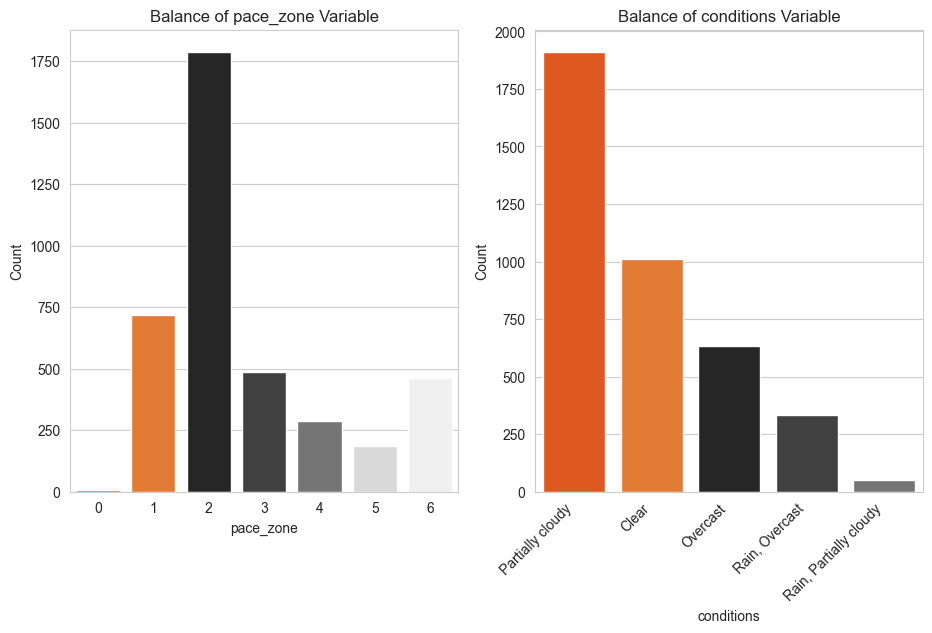

In [47]:
# Overall Figure (2x4 with 8 subplots). Flattening the axes will help seaborn do backend stuff faster.
fig, axes = plt.subplots(1, 2, figsize=(11, 6))
axes = axes.flatten()

# For each of our categorical columns, bar plot it and add it to the appropriate slot in the overall fig
# Enumerate because we need an iterator and the column
for i, column in enumerate(['pace_zone', 'conditions']):
    
    # Create a little mini df from the result of value_counts(), so we can plot it
    values = pd.DataFrame(running_data[column].value_counts().reset_index())
    values.columns = [column, 'Count']
    
    sns.barplot(data=values, x=column, y='Count', ax=axes[i])
    axes[i].set_title(f'Balance of {column} Variable')

axes[1].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
plt.show()

It looks like we can change `conditions` and `pace_zone` to categorical datatypes. Furthermore, `datetime` loaded in as an object. We'll want to update that to the appropriate datatype here as well.

In [48]:
running_data['datetime'] = pd.to_datetime(running_data['datetime'])
running_data['conditions'] = running_data['conditions'].astype('category')
running_data['pace_zone'] = running_data['pace_zone'].astype('category')

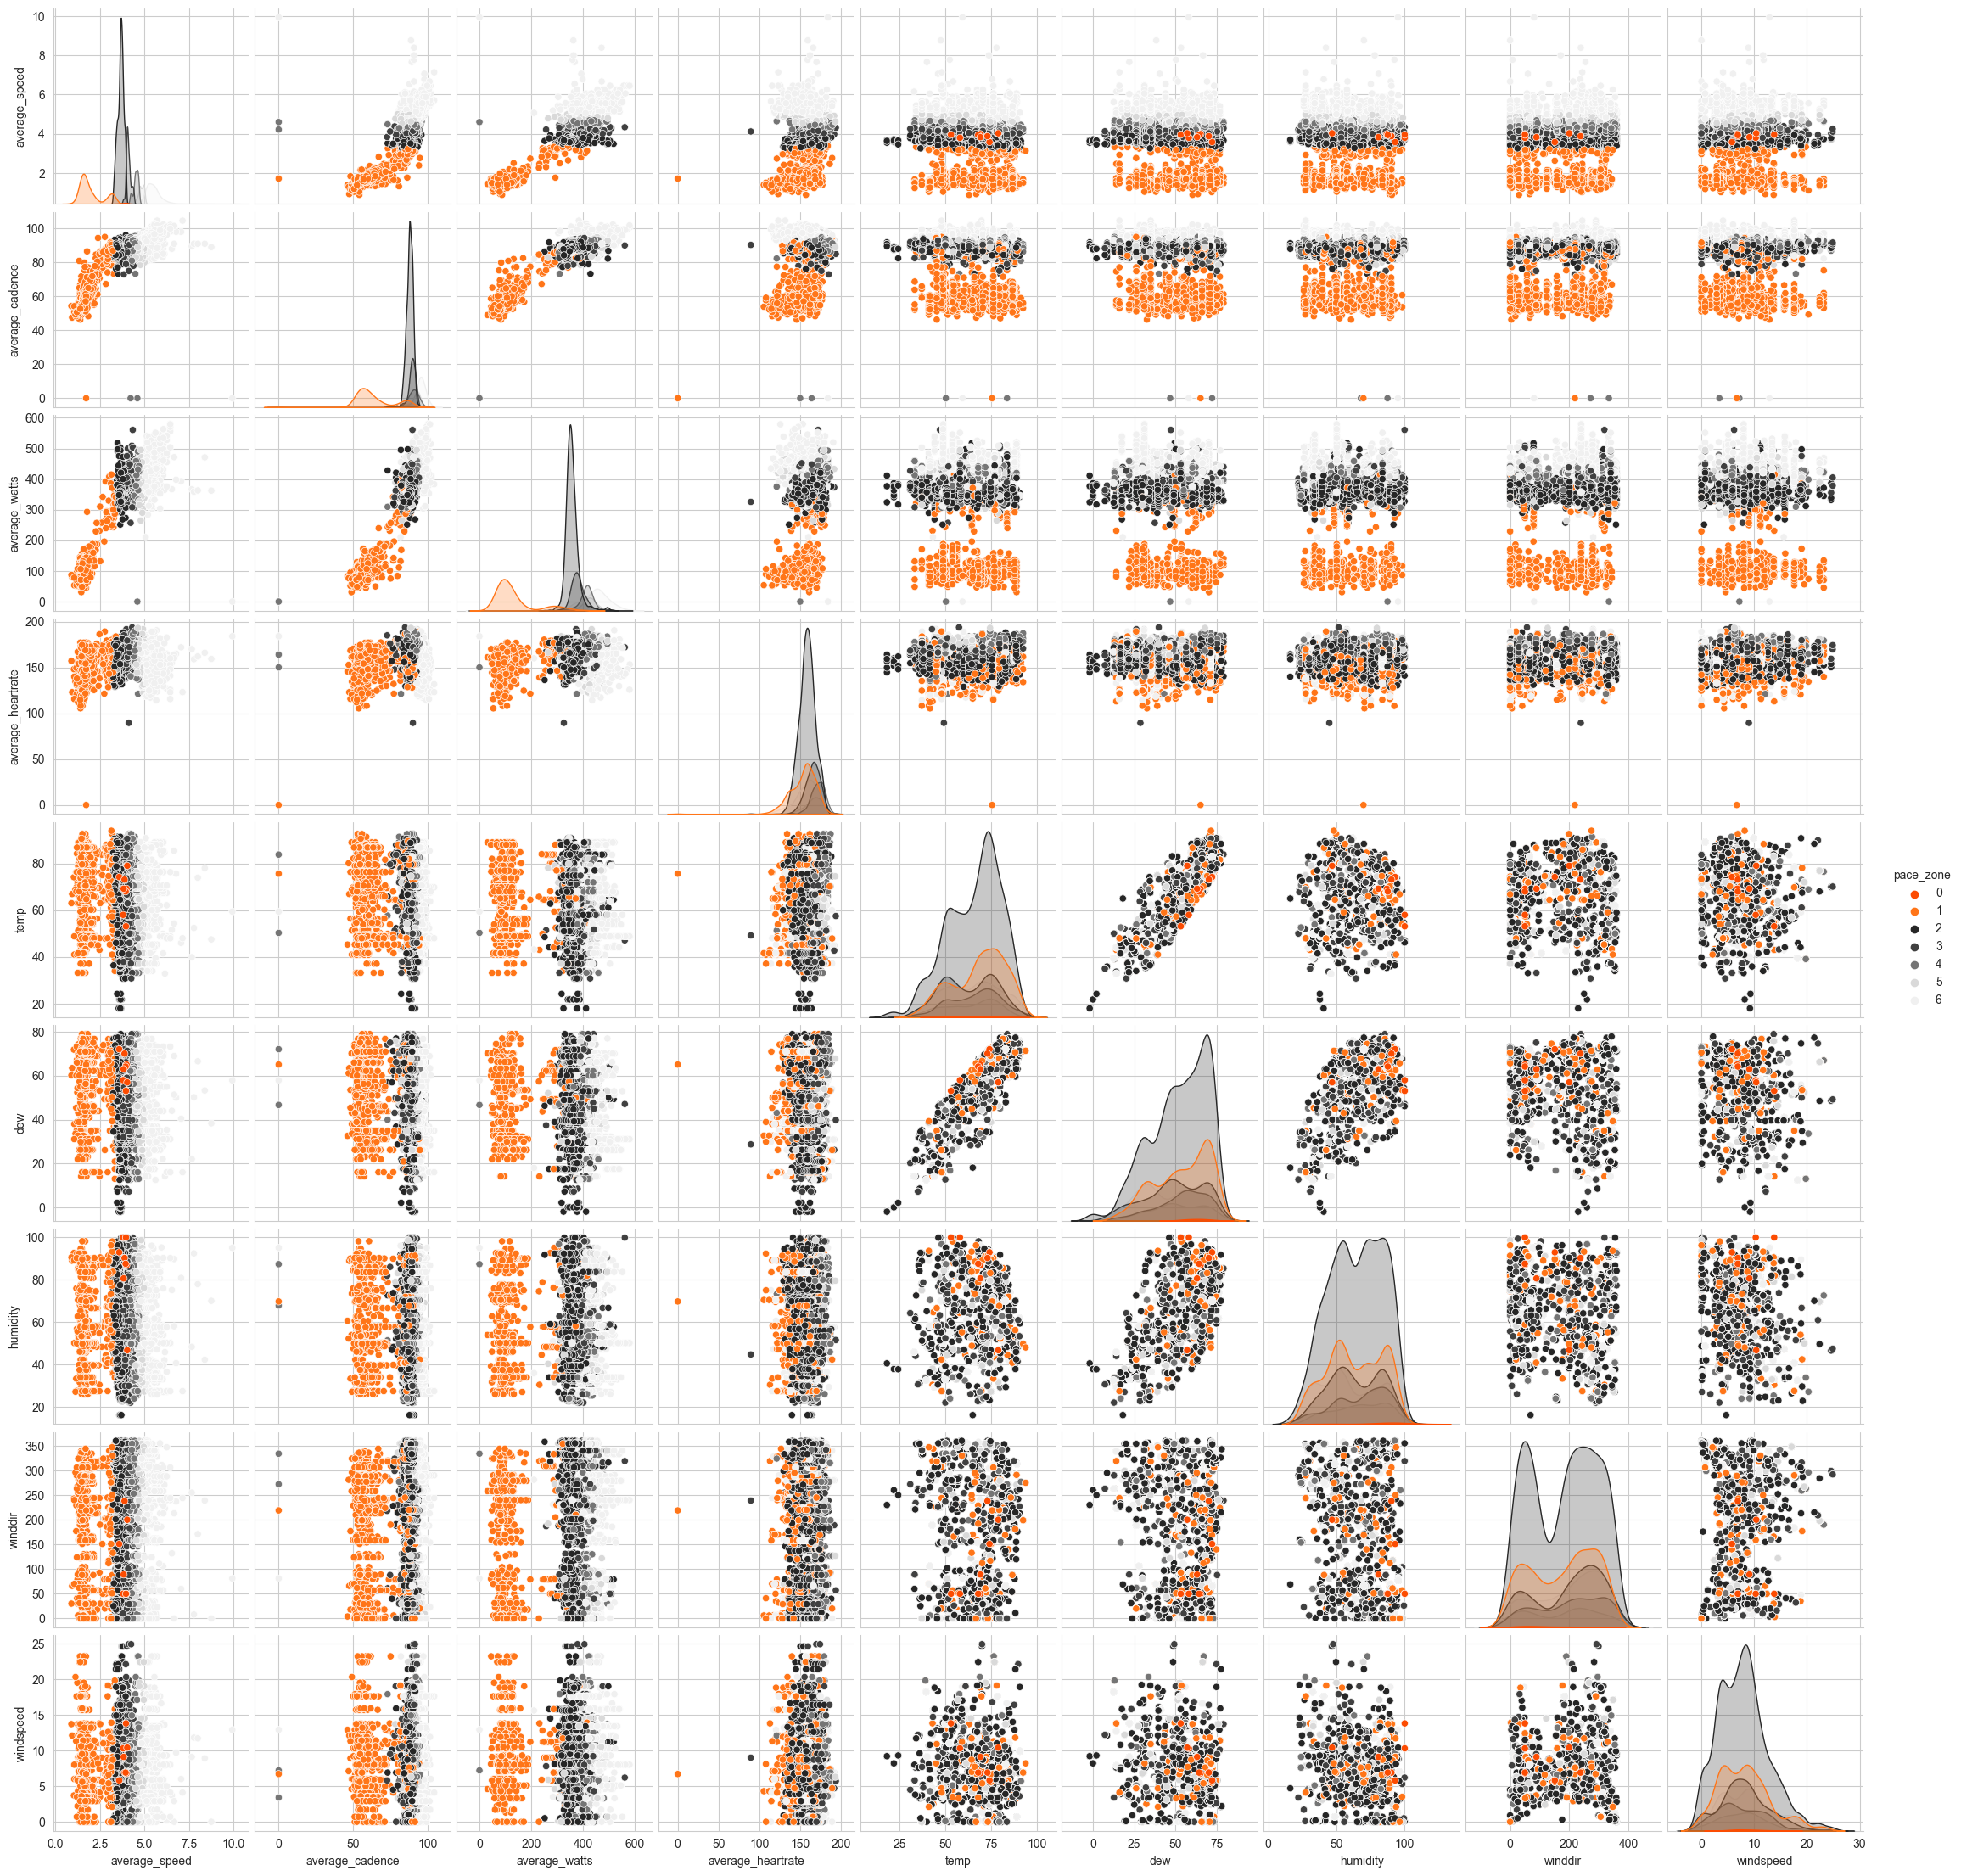

In [49]:
# running info pairplot
sns.pairplot(data=running_data, vars=['average_speed', 'average_cadence', 'average_watts', 'average_heartrate', 'temp', 'dew', 'humidity', 'winddir', 'windspeed'], hue='pace_zone');

/Users/bennett/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


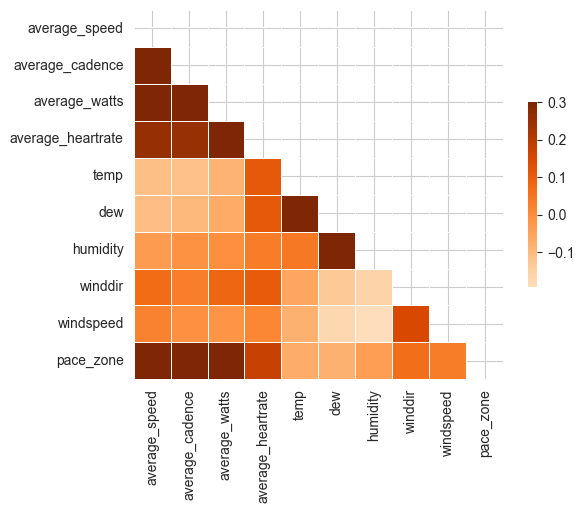

In [50]:
# These parameters for the sns.heatmap are taken from sns.heatmap documentation. It creates a heatmap that very much resembles the corrplot() from R
corr = running_data[['average_speed', 'average_cadence', 'average_watts', 'average_heartrate', 'temp', 'dew', 'humidity', 'winddir', 'windspeed', 'pace_zone']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='Oranges', annot=True,
            vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={'shrink': .5}
            );

We're not really seeing much here. Just like in my research, it's really hard to get a perfect understanding of how the weather is impacting the running variables. This also might partially be due to me being stubborn and trying to hit ranges regardless of the conditions. If this is the case, heartrate should be a good indicator of the relationship.

Lastly, there are a few of my earlier workouts that don't have heartrate information. This is because I was not using a fitness watch earlier on. We should limit the data to after I got my garmin, by filtering out activity laps where any heartrate related data is missing. Furthermore, there are a noticeable amount of missing values in average watts. Since most of the other variables together probably do a good job of conveying power anyways, we can just remove the column to keep our dataset larger. 

In [51]:
running_data.drop(columns=['average_watts'], inplace=True)
running_data.dropna(subset=['average_heartrate'], inplace=True)

running_data.dropna(subset=['average_cadence'], inplace=True)       # 3 instances of missing cadence, removing these shouldn't hurt the overall results

# Feature Engineering

A few things need to be done here.
- I want to keep track of how much distance has elapsed in the given workout (we can just keep summing distance by lap for each activity). I know that the further and longer an activity goes on, there's some level of impact on your internals. We need to account for it
- I also want to make a conversion for distance and time elapsed to get a mile per min pace variable. This will be helpful for post modelling when we want to chart out the CAPi paces.

## Distance Covered Prior and Time Covered Prior

Obviously, a run gets harder the longer it goes on, and the further we go, lets do some aggregations to take account for this when we move to model the data

In [52]:
running_data = running_data.sort_values(by=['activity_id', 'name'])

running_data['distance_covered_prior'] = running_data.groupby('activity_id')['distance'].cumsum() - running_data['distance']
running_data['time_elapsed_prior'] = running_data.groupby('activity_id')['elapsed_time'].cumsum() - running_data['elapsed_time']

In [53]:
running_data[['activity_id', 'name', 'distance', 'distance_covered_prior', 'elapsed_time', 'time_elapsed_prior']]

activity_id   name  distance  distance_covered_prior  elapsed_time  \
4158   7363015746  Lap 1   1609.34                    0.00           498   
4159   7363015746  Lap 2   1609.34                 1609.34           472   
4160   7363015746  Lap 3   1609.34                 3218.68           469   
4161   7363015746  Lap 4   1263.33                 4828.02           360   
4154   7365609810  Lap 1   1609.34                    0.00           361   
...           ...    ...       ...                     ...           ...   
2     10417227668  Lap 2   1609.34                 1609.34           403   
4     10417227668  Lap 3   1609.34                 3218.68           442   
6     10417227668  Lap 4   1609.34                 4828.02           388   
8     10417227668  Lap 5   1609.34                 6437.36           394   
10    10417227668  Lap 6   1609.30                 8046.70           412   

      time_elapsed_prior  
4158                   0  
4159                 498  
4160                 970  
4161                1439  
4154                   0  
...                  ...  
2                    404  
4                    807  
6                   1249  
8                   1637  
10                  2031  

[3897 rows x 6 columns]

## Pace per Mile (M:SSmi)

This is not crucial for modeling, but we will need to convert our predicted results into this format so that they are digestible for users. We'll be predicting elapsed time (which really represents how fast you're going, since we have a defined distance) for a lap, but the variable will go into this calculation. Let's have it built here so we don't need to worry about figuring it out later.

In [54]:
# Used chatGPT for this. I didn't want to have to think about this that long
def pace_conversion(row):
    # Conversion factors
    meters_to_miles = 0.000621371
    seconds_to_minutes = 1 / 60.0

    # Convert distance to miles
    distance_miles = row['distance'] * meters_to_miles

    # Convert elapsed time to minutes
    elapsed_time_minutes = row['elapsed_time'] * seconds_to_minutes

    # Calculate pace in minutes per mile
    pace_minutes_per_mile = elapsed_time_minutes / distance_miles

    # Format the result in M:SSmi format
    pace_formatted = f"{int(pace_minutes_per_mile // 1):02}:{int((pace_minutes_per_mile % 1) * 60):02}mi"

    return pace_formatted

running_data['pace_formatted'] = running_data.apply(pace_conversion, axis=1)

In [55]:
running_data[['activity_id', 'name', 'distance', 'elapsed_time', 'pace_formatted']]

activity_id   name  distance  elapsed_time pace_formatted
4158   7363015746  Lap 1   1609.34           498        08:18mi
4159   7363015746  Lap 2   1609.34           472        07:52mi
4160   7363015746  Lap 3   1609.34           469        07:49mi
4161   7363015746  Lap 4   1263.33           360        07:38mi
4154   7365609810  Lap 1   1609.34           361        06:01mi
...           ...    ...       ...           ...            ...
2     10417227668  Lap 2   1609.34           403        06:43mi
4     10417227668  Lap 3   1609.34           442        07:22mi
6     10417227668  Lap 4   1609.34           388        06:28mi
8     10417227668  Lap 5   1609.34           394        06:34mi
10    10417227668  Lap 6   1609.30           412        06:52mi

[3897 rows x 5 columns]

## Preprocessing and Pipeline

We'll explore options here before we integrate the model into the app workflow.

In [56]:
running_data.describe().transpose()

count                           mean  \
activity_id             3897.0              8797012678.671799   
id                      3897.0             29783490600.363358   
split                   3897.0                        9.18681   
elapsed_time            3897.0                     274.950731   
distance                3897.0                       998.9305   
average_speed           3897.0                       3.738894   
average_heartrate       3897.0                     159.506723   
average_cadence         3897.0                      85.090146   
max_speed               3897.0                       4.836072   
max_heartrate           3897.0                     168.800359   
total_elevation_gain    3897.0                       6.065127   
start_lat               3897.0                      37.294673   
start_long              3897.0                      -82.50886   
datetime                  3897  2023-03-16 17:45:51.963048192   
temp                    3897.0                      65.531229   
dew                     3897.0                      51.542802   
humidity                3897.0                      63.556864   
precip                  3897.0                       0.004893   
snowdepth               3897.0                            0.0   
windspeed               3897.0                       8.083577   
winddir                 3897.0                       186.2602   
sealevelpressure        3897.0                    1017.051399   
cloudcover              3897.0                      53.563023   
visibility              3897.0                       9.265307   
distance_covered_prior  3897.0                    6525.292017   
time_elapsed_prior      3897.0                    1823.651527   

                                        min                  25%  \
activity_id                    7363015746.0         8020006304.0   
id                            24436372656.0        26806037249.0   
split                                   1.0                  4.0   
elapsed_time                            1.0                 60.0   
distance                               6.51                200.0   
average_speed                          0.89                 3.45   
average_heartrate                       0.0                152.6   
average_cadence                         0.0                 85.7   
max_speed                             1.206                4.284   
max_heartrate                         119.0                162.0   
total_elevation_gain                    0.0                  0.0   
start_lat                         30.335528            35.161128   
start_long                      -123.964882           -89.988721   
datetime                2022-06-24 18:00:00  2022-10-25 20:00:00   
temp                                   18.0                 53.9   
dew                                    -2.0                 39.3   
humidity                               16.2                 48.7   
precip                                  0.0                  0.0   
snowdepth                               0.0                  0.0   
windspeed                               0.0                  4.6   
winddir                                 0.0                 79.0   
sealevelpressure                      989.3               1012.7   
cloudcover                              0.0                 18.4   
visibility                              0.0                  9.9   
distance_covered_prior                  0.0              2809.34   
time_elapsed_prior                      0.0                808.0   

                                        50%                  75%  \
activity_id                    8820119132.0         9616766472.0   
id                            29935284168.0        32868306131.0   
split                                   7.0                 13.0   
elapsed_time                          375.0                440.0   
distance                            1608.96              1609.34   
average_speed           

In [57]:
running_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3897 entries, 4158 to 10
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   activity_id             3897 non-null   int64         
 1   id                      3897 non-null   int64         
 2   name                    3897 non-null   object        
 3   split                   3897 non-null   int64         
 4   elapsed_time            3897 non-null   int64         
 5   distance                3897 non-null   float64       
 6   average_speed           3897 non-null   float64       
 7   average_heartrate       3897 non-null   float64       
 8   average_cadence         3897 non-null   float64       
 9   max_speed               3897 non-null   float64       
 10  max_heartrate           3897 non-null   float64       
 11  total_elevation_gain    3897 non-null   float64       
 12  pace_zone               3897 non-null   category    

In [58]:
from sklearn.model_selection import train_test_split

y = running_data[['elapsed_time']]
X = running_data[['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 'max_heartrate', 
                  'total_elevation_gain', 'pace_zone', 'temp', 'dew', 'humidity','windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'distance_covered_prior', 'time_elapsed_prior', 'conditions']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

nums = ['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 
        'max_heartrate', 'total_elevation_gain', 'temp', 'dew', 'humidity', 'windspeed', 
        'winddir', 'sealevelpressure', 'cloudcover', 'distance_covered_prior', 'time_elapsed_prior']

cats =  ['pace_zone']
dummies = ['conditions']

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),        # just for reproducibility purposes
    ('scale', StandardScaler())
])

# pace zone is actually ordinal with some sort of scale (we need to account for that)
cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('categorize', OrdinalEncoder()),
])

# we can't say much about how conditions are sequentially better than others in an ordinal sense.
dummy_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),       # just for reproducibility purposes
    ('categorize', OneHotEncoder(handle_unknown='ignore')),
])  

In [60]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer(transformers=[
    ('numeric columns', num_pipe, nums),
    ('categorical columns', cat_pipe, cats),
    ('dummy columns', dummy_pipe, dummies)],
    remainder='passthrough'
)

In [61]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('rf', RandomForestRegressor(random_state=42))
])

xgbr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('xgboost', XGBRegressor(objective='reg:squarederror', alpha=1, random_state=42))
])

ridge_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('ridge', Ridge(random_state=42))
])

svm_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('svm', SVR())
])

reg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('linreg', LinearRegression())
])

## Model Tuning

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

# Make workflow a little easier and cleaner
def tuner(model=sklearn.pipeline.Pipeline, dist=dict):
    rs_cv = RandomizedSearchCV(estimator=model, param_distributions=dist, n_iter=1000, scoring='r2', cv=10, n_jobs=-1, random_state=42)
    if any(isinstance(step[1], XGBRegressor) for step in model.steps):
        rs_cv.fit(X_train, y_train)
    else:
        rs_cv.fit(X_train, y_train.values.ravel())
        
    print("Best Hyperparameters:", rs_cv.best_params_)
    print("Best Score:", rs_cv.best_score_)
    print("")
    return rs_cv.best_estimator_

def tester(model=sklearn.pipeline.Pipeline):
    predictions = model.predict(X_test)
    print(f'{model} Performance on Holdout')
    
    if any(isinstance(step[1], XGBRegressor) for step in model.steps):
        test_mse = MSE(y_test, predictions, squared=False)
        print(f'Test RMSE: {test_mse}')

        test_mape = MAPE(y_test, predictions)
        print(f'Test MAPE: {test_mape}')
        
    else:
        test_mse = MSE(y_test.values.ravel(), predictions, squared=False)
        print(f'Test RMSE: {test_mse}')

        test_mape = MAPE(y_test.values.ravel(), predictions)
        print(f'Test MAPE: {test_mape}')
    

## XGBoost

In [22]:
xgb_dists = {
    'xgboost__learning_rate': np.linspace(0.01, 0.3, 30),
    'xgboost__n_estimators': np.arange(50, 1001, 50),
    'xgboost__gamma': np.arange(0, 0.4, .01),
    'xgboost__max_depth': np.arange(3, 20, 1),
    'xgboost__min_child_weight': np.arange(1, 10, 1),
    'xgboost__subsample': np.arange(0.5, 1, 0.01),
    'xgboost__colsample_bytree': np.arange(0.5, 1, 0.01),
    'xgboost__reg_alpha': np.logspace(-5, 2, 8)
}

best_xgb = tuner(xgbr_pipeline, xgb_dists)

tester(best_xgb)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Random Forest

In [23]:
rf_dists = {
    "rf__n_estimators": np.arange(10, 100, 1),
    "rf__max_depth": [None, 3, 5, 10],
    "rf__min_samples_split": np.arange(2, 20, 1),
    "rf__min_samples_leaf": np.arange(1, 20, 1),
    "rf__max_features": [0.5, 1, "sqrt", "log2"],
    "rf__max_samples": [2805]
}

best_rf = tuner(rf_pipeline, rf_dists)

tester(best_rf)

Best Hyperparameters: {'rf__n_estimators': 99, 'rf__min_samples_split': 15, 'rf__min_samples_leaf': 3, 'rf__max_samples': 2805, 'rf__max_features': 0.5, 'rf__max_depth': None}
Best Score: 0.978632078635045

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
    

## Support Vector Machine (Regression)

In [26]:
# rbf test
svm_dists = {
    "svm__C": np.logspace(-3, 3, 14),
    "svm__kernel": ['rbf'],
    "svm__gamma": np.logspace(-3, 3, 14)
}

best_svm = tuner(svm_pipeline, svm_dists)

tester(best_svm)

/Users/bennett/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 196 is smaller than n_iter=1000. Running 196 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'svm__kernel': 'rbf', 'svm__gamma': 0.024244620170823284, 'svm__C': 1000.0}
Best Score: 0.9765602238841715
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
                                                   'total_elevation_gain',
      

## Linear Regression

In [28]:
best_reg = reg_pipeline.fit(X_train, y_train)

predictions = best_reg.predict(X_test)

test_mse = MSE(y_test, predictions, squared=False)
print(f'Test RMSE: {test_mse}')

test_mape = MAPE(y_test, predictions)
print(f'Test MAPE: {test_mape}')

Test RMSE: 39.72724940454856
Test MAPE: 0.5688990484082568


## Ridge Regression

In [30]:
from scipy.stats import uniform

param_dist = {
    'ridge__alpha': uniform(0, 10)
}

best_ridge = tuner(ridge_pipeline, param_dist)

tester(best_ridge)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


It seems that no matter which model we try, we're really struggling to get a near perfect prediction. 30 seconds off on average is just too much considering the use case of the model. Let's try and readjust the data

## Reassessing the Data

Let's see if there are any splits that happen within less than 15 seconds (this would indicate the end of a run that just inched over a clean mileage. For example a 6.01 mile run. The .01 isn't very useful to us, so we should drop them)

In [22]:
running_data[running_data['elapsed_time'] < 15].sort_values(by='distance', ascending=False)

activity_id           id    name  split  elapsed_time  distance  \
380   10079450999  34582670979   Lap 7      7            11     51.51   
1649   9042280418  30773898566   Lap 8      8            11     48.75   
3406   7817504952  26055887765   Lap 8      8            12     43.84   
3153   8065139844  26973673902   Lap 5      5             9     41.64   
1913   8861393920  30094063829  Lap 14     14            10     40.01   
...           ...          ...     ...    ...           ...       ...   
526    9989579197  34242965908  Lap 17     17             6      8.43   
329   10115988131  34718976971  Lap 16     16             1      8.39   
534    9983352313  34220910835   Lap 7      7             2      8.24   
299   10132623767  34785106156   Lap 6      6             1      7.78   
527    9989579197  34242965910  Lap 18     18             7      6.51   

      average_speed  average_heartrate  average_cadence  max_speed  ...  \
380            4.68              177.0             85.2      4.928  ...   
1649           4.43              186.5             88.0      4.408  ...   
3406           3.65              165.2             86.5      3.527  ...   
3153           4.63              180.4             91.9      5.794  ...   
1913           4.00              172.8             89.0      4.126  ...   
...             ...                ...              ...        ...  ...   
526            1.41              124.2             51.2      1.440  ...   
329            8.39              166.0             91.0      4.120  ...   
534            4.12              167.0             85.0      3.168  ...   
299            7.78              159.0             91.0      3.678  ...   
527            0.93              123.0             47.5      1.206  ...   

      snowdepth  windspeed winddir  sealevelpressure  cloudcover visibility  \
380           0       12.9    81.0             989.3       100.0        2.4   
1649          0        5.3   315.0            1014.3        40.9        9.9   
3406          0        1.2    58.0            1020.8        29.1        9.9   
3153          0        6.7   146.0            1019.1        23.7        9.9   
1913          0       10.5    41.0            1030.5         1.3        9.9   
...         ...        ...     ...               ...         ...        ...   
526           0       12.1    66.0            1017.5        98.7        8.5   
329           0        8.9   239.0            1015.3        39.0        9.9   
534           0        6.8   151.0            1023.5        21.1        9.9   
299           0       11.8     8.0            1004.9       100.0        4.4   
527           0       12.1    66.0            1017.5        98.7        8.5   

            conditions  distance_covered_prior  time_elapsed_prior  \
380     Rain, Overcast                12355.81                2955   
1649  Partially cloudy                11279.40                2655   
3406  Partially cloudy                11265.00                3254   
3153  Partially cloudy                 6437.00                1615   
1913             Clear                 6985.97                2067   
...                ...                     ...                 ...   
526           Overcast                 4078.49                1220   
329   Partially cloudy                 5607.35                1674   
534   Partially cloudy                 9656.00                2731   
299     Rain, Overcast                 8046.00                2095   
527           Overcast                 4086.92                1226   

      pace_formatted  
380          05:43mi  
1649         06:03mi  
3406         07:20mi  
3153         05:47mi  
1913         06:42mi  
...              ...  
526          19:05mi  
329          03:11mi  
534          06:30mi  
299          03:26mi  
527          28:50mi  

[265 rows x 30 columns]

In [23]:
running_data = running_data[running_data['elapsed_time'] > 15]

Another likely issue is walks or jogs in between speed work sets. This is a big jump in pace with the temperature remaining about the same. Initially i thought pace zone might mitigate this, but lets remove and retrain to see if we get better results. For me personally, I know that anything slower than 8:00mi and above 160 heartrate is probably a walk in between sets. Let's remove those instances

In [24]:
running_data['minutes_per_mile'] = (running_data['elapsed_time'] / 60) / (running_data['distance'] / 1609)
cooldowns = running_data[(running_data['average_heartrate'] > 150) & (running_data['minutes_per_mile'] > 9)].sort_values('pace_formatted', ascending=False)

cooldowns

activity_id           id    name  split  elapsed_time  distance  \
1270   9345265865  31877063334  Lap 10     10           261     77.18   
3786   7584315958  25215190386   Lap 8      8           532     20.47   
2749   8270951641  27762673221   Lap 8      8           159     77.47   
961    9674487399  33079854869   Lap 8      8           182     94.56   
721    9882287466  33847712137  Lap 12     12           126     73.12   
...           ...          ...     ...    ...           ...       ...   
1237   9374114343  31983652563   Lap 6      6           546   1609.00   
3765   7594397697  25251559127  Lap 15     15           180    531.31   
1160   9434463800  32199689933   Lap 9      9           544   1609.34   
1170   9421602794  32155335688   Lap 6      6           544   1609.34   
693    9900885708  33914000269  Lap 32     32            60    178.44   

      average_speed  average_heartrate  average_cadence  max_speed  ...  \
1270           1.29              152.8             47.1      3.892  ...   
3786           2.92              170.0             85.0      3.398  ...   
2749           1.29              153.8             52.1      3.896  ...   
961            1.58              165.8             60.9      3.924  ...   
721            1.22              154.4             54.6      4.346  ...   
...             ...                ...              ...        ...  ...   
1237           4.38              167.3             89.0      5.252  ...   
3765           2.95              160.3             81.9      3.316  ...   
1160           4.34              157.2             89.7      4.974  ...   
1170           3.25              166.4             84.2      5.828  ...   
693            2.97              158.1             78.6      3.390  ...   

      windspeed  winddir sealevelpressure  cloudcover  visibility  \
1270        7.1    281.0           1009.0        86.4         9.9   
3786        3.1    245.0           1018.9         4.4         9.9   
2749        5.8     89.0           1033.4        89.5         9.9   
961        12.3    182.0           1003.1        86.7         9.9   
721        19.5    267.0           1009.5        80.3         9.9   
...         ...      ...              ...         ...         ...   
1237        0.0    360.0           1015.2        49.7         8.1   
3765       12.6    319.0           1023.2        88.7         9.9   
1160        6.0    263.0           1013.3        58.8         9.9   
1170        8.8     38.0           1011.5        94.8         8.8   
693        11.2     79.0           1029.6        78.0         9.9   

            conditions  distance_covered_prior  time_elapsed_prior  \
1270  Partially cloudy                 1609.34                 433   
3786             Clear                11264.99                3296   
2749  Partially cloudy                11641.61                3040   
961   Partially cloudy                 9367.05                2485   
721   Partially cloudy                 3313.79                 877   
...                ...                     ...                 ...   
1237  Partially cloudy                19322.84                5529   
3765  Partially cloudy                 7545.24                2066   
1160  Partially cloudy                11699.10                3362   
1170    Rain, Overcast                16322.49                4621   
693   Partially cloudy                 7828.56                2543   

      pace_formatted  minutes_per_mile  
1270         90:42mi         90.686059  
3786        697:05mi        696.945123  
2749         55:03mi         55.038725  
961          51:37mi         51.614143  
721          46:13mi         46.210339  
...              ...               ...  
1237         09:06mi          9.100000  
3765         09:05mi          9.085092  
1160         09:04mi          9.064751  
1170         09:04mi          9.064751  
693          09:01mi          9.017037  

[393 rows x 31 columns]

In [25]:
running_data = running_data[~running_data.isin(cooldowns)].dropna()
running_data = running_data.astype(cooldowns.dtypes)

running_data

activity_id           id   name  split  elapsed_time  distance  \
4158   7363015746  24436372656  Lap 1      1           498   1609.34   
4159   7363015746  24436372658  Lap 2      2           472   1609.34   
4160   7363015746  24436372660  Lap 3      3           469   1609.34   
4161   7363015746  24436372661  Lap 4      4           360   1263.33   
4154   7365609810  24446391615  Lap 1      1           361   1609.34   
...           ...          ...    ...    ...           ...       ...   
2     10417227668  35896190591  Lap 2      2           403   1609.34   
4     10417227668  35896190594  Lap 3      3           442   1609.34   
6     10417227668  35896190599  Lap 4      4           388   1609.34   
8     10417227668  35896190600  Lap 5      5           394   1609.34   
10    10417227668  35896190601  Lap 6      6           412   1609.30   

      average_speed  average_heartrate  average_cadence  max_speed  ...  \
4158           3.23              144.4             87.0      4.546  ...   
4159           3.41              157.9             91.1      4.394  ...   
4160           3.43              161.6             90.2      4.241  ...   
4161           3.51              163.9             88.7      3.961  ...   
4154           4.46              168.2             92.8      5.458  ...   
...             ...                ...              ...        ...  ...   
2              3.99              166.5             90.4      4.688  ...   
4              4.01              149.4             90.6      5.122  ...   
6              4.15              152.9             91.3      4.976  ...   
8              4.08              155.1             88.4      5.144  ...   
10             3.91              163.4             86.1      4.440  ...   

      windspeed  winddir sealevelpressure  cloudcover  visibility  \
4158        4.6    176.0           1015.0        43.5         9.9   
4159        4.6    176.0           1015.0        43.5         9.9   
4160        4.6    176.0           1015.0        43.5         9.9   
4161        3.9    155.0           1015.0        46.0         9.9   
4154        6.3    127.0           1020.0        88.2         9.9   
...         ...      ...              ...         ...         ...   
2           0.1    354.0           1029.1         2.4         9.9   
4           0.1    354.0           1029.1         2.4         9.9   
6           0.1    354.0           1029.1         2.4         9.9   
8           0.1    354.0           1029.1         2.4         9.9   
10          0.1    354.0           1029.1         2.4         9.9   

            conditions  distance_covered_prior  time_elapsed_prior  \
4158  Partially cloudy                    0.00                   0   
4159  Partially cloudy                 1609.34                 498   
4160  Partially cloudy                 3218.68                 970   
4161  Partially cloudy                 4828.02                1439   
4154  Partially cloudy                    0.00                   0   
...                ...                     ...                 ...   
2                Clear                 1609.34                 404   
4                Clear                 3218.68                 807   
6                Clear                 4828.02                1249   
8                Clear                 6437.36                1637   
10               Clear                 8046.70                2031   

      pace_formatted  minutes_per_mile  
4158         08:18mi          8.298246  
4159         07:52mi          7.865005  
4160         07:49mi          7.815015  
4161         07:38mi          7.641709  
4154         06:01mi          6.015396  
...              ...               ...  
2            06:43mi          6.715248  
4            07:22mi          7.365110  
6            06:28mi          6.465300  
8            06:34mi          6.565279  
10           06:52mi          6.865387  

[3237 rows x 31 columns]

# Model Reevaluation

In [60]:
y = running_data[['elapsed_time']]
X = running_data[['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 'max_heartrate', 
                  'total_elevation_gain', 'pace_zone', 'temp', 'dew', 'humidity','windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'distance_covered_prior', 'time_elapsed_prior', 'conditions']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## XGBoost

In [61]:
xgb_dists = {
    'xgboost__learning_rate': np.linspace(0.01, 0.3, 30),
    'xgboost__n_estimators': np.arange(50, 1001, 50),
    'xgboost__gamma': np.arange(0, 0.4, .01),
    'xgboost__max_depth': np.arange(3, 20, 1),
    'xgboost__min_child_weight': np.arange(1, 10, 1),
    'xgboost__subsample': np.arange(0.5, 1, 0.01),
    'xgboost__colsample_bytree': np.arange(0.5, 1, 0.01),
    'xgboost__reg_alpha': np.logspace(-5, 2, 8)
}

best_xgb = tuner(xgbr_pipeline, xgb_dists)

tester(best_xgb)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/bennett/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Random Forest

In [65]:
rf_dists = {
    "rf__n_estimators": np.arange(10, 100, 1),
    "rf__max_depth": [None, 3, 5, 10],
    "rf__min_samples_split": np.arange(2, 20, 1),
    "rf__min_samples_leaf": np.arange(1, 20, 1),
    "rf__max_features": [0.5, 1, "sqrt", "log2"],
    "rf__max_samples": [2330]
}

best_rf = tuner(rf_pipeline, rf_dists)

tester(best_rf)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


An average of about 20 seconds off and 2% error is solid considering our limitations. Let's feature select and see if we can reduce the error further.

In [63]:
# Model and feature importance array
rf_model = best_rf.named_steps['rf']
feature_importances = rf_model.feature_importances_

# feature names prior to scaling
numeric_feature_names = rf_pipeline.named_steps['preprocess'].transformers_[0][1].named_steps['scale'].get_feature_names_out(input_features=nums)
categorical_feature_names = rf_pipeline.named_steps['preprocess'].transformers_[1][1].named_steps['categorize'].get_feature_names_out(input_features=cats)
dummy_feature_names = rf_pipeline.named_steps['preprocess'].transformers_[2][1].named_steps['categorize'].get_feature_names_out(input_features=dummies)

# combine them and sort
feature_names = np.concatenate((numeric_feature_names, categorical_feature_names, dummy_feature_names))
sorted_indices = np.argsort(feature_importances)

# matploblib stuff
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align="center")
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

# Reeval with Feature Selection

In [38]:
y = running_data[['elapsed_time']]
X = running_data[['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 'max_heartrate', 
                  'total_elevation_gain', 'pace_zone', 'temp', 'dew', 'humidity','windspeed', 'winddir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [39]:
nums = ['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 
        'max_heartrate', 'total_elevation_gain', 'temp', 'dew', 'humidity', 'windspeed', 
        'winddir']

cats =  ['pace_zone']

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),        # just for reproducibility purposes
    ('scale', StandardScaler())
])

# pace zone is actually ordinal with some sort of scale (we need to account for that)
cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('categorize', OrdinalEncoder()),
])


preprocessing = ColumnTransformer(transformers=[
    ('numeric columns', num_pipe, nums),
    ('categorical columns', cat_pipe, cats)],
    remainder='passthrough'
)

In [28]:
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('rf', RandomForestRegressor(random_state=42))
])

xgbr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('xgboost', XGBRegressor(objective='reg:squarederror', alpha=1, random_state=42))
])

## XGBoost

In [29]:
xgb_dists = {
    'xgboost__learning_rate': np.linspace(0.01, 0.3, 30),
    'xgboost__n_estimators': np.arange(50, 1001, 50),
    'xgboost__gamma': np.arange(0, 0.4, .01),
    'xgboost__max_depth': np.arange(3, 20, 1),
    'xgboost__min_child_weight': np.arange(1, 10, 1),
    'xgboost__subsample': np.arange(0.5, 1, 0.01),
    'xgboost__colsample_bytree': np.arange(0.5, 1, 0.01),
    'xgboost__reg_alpha': np.logspace(-5, 2, 8)
}

best_xgb = tuner(xgbr_pipeline, xgb_dists)

tester(best_xgb)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/bennett/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Random Forest

In [30]:
rf_dists = {
    "rf__n_estimators": np.arange(10, 100, 1),
    "rf__max_depth": [None, 3, 5, 10],
    "rf__min_samples_split": np.arange(2, 20, 1),
    "rf__min_samples_leaf": np.arange(1, 20, 1),
    "rf__max_features": [0.5, 1, "sqrt", "log2"],
    "rf__max_samples": [2330]
}

best_rf = tuner(rf_pipeline, rf_dists)

tester(best_rf)

/Users/bennett/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Best Hyperparameters: {'rf__n_estimators': 35, 'rf__min_samples_split': 13, 'rf__min_samples_leaf': 1, 'rf__max_samples': 2330, 'rf__max_features': 0.5, 'rf__max_depth': None}
Best Score: 0.979651997583912

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                        

## Send Model to Pickle

In [64]:
import pickle

# Model
with open('CAPi.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)
    
# Feature Names
with open('CAPi_features.txt', 'w') as file:
    file.write("\n".join(feature_names))

with open('CAPi_preprocessing.pkl', 'wb') as file:
    pickle.dump(xgbr_pipeline, file)